### Importing Modules

In [1]:
# !pip3 install gensim
# !pip3 install keras
# !pip3 install tensorflow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re   # Provides regular expression operations
import matplotlib.pyplot as plt
import time
import pickle
import gensim


# Scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Installing Packages

In [3]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


In [4]:
# # Mounting Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Loading Data

In [5]:
# Paths
csv_file = r"twitter_dataset.csv"

# Since labels were not there for the dataset we create Column Labels.
# target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
# ids: The id of the tweet ( 2087)
# date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
# flag: The query (lyx). If there is no query, then this value is NO_QUERY.
# user: the user that tweeted (robotickilldozr)
# text: the text of the tweet (Lyx is cool)
column_labels = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [6]:
# Specify the encoding as 'ISO-8859-1'
df = pd.read_csv(csv_file, encoding='ISO-8859-1', header=None, names=column_labels)

In [7]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [11]:
# Checking unique values in cloumns
print(df['target'].unique())   # It is only giving two values 0 and 4 it mean there are no neutral twits
print(df['flag'].unique())     # It is giving only "NOQUERY" So no use of this column can be removed

[0 4]
['NO_QUERY']


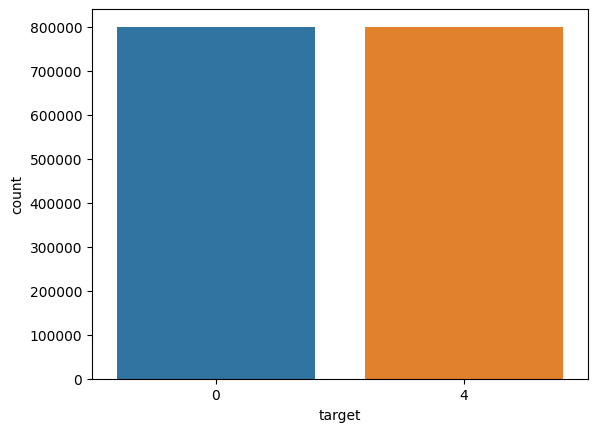

In [12]:
# Count plot (Helps finding imbalnce in the data)
sns.countplot(x=df['target'])
plt.show()

In [13]:
df = df.drop(columns = ['ids','date','flag','user'])

In [14]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


# Preprocessing

In [15]:
# PreProcessing
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"   # Using this to remove ids or any links
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
df.text = df.text.apply(lambda x: preprocess(x))

In [17]:
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

In [18]:
# Splitting data
df_train, df_test = train_test_split(df,test_size = 0.2)

In [19]:
documents = [_text.split() for _text in df_train.text]

In [20]:
print(documents[0])
len(documents[0])

['oh', 'gm', 'actually', 'general', 'motors', 'wild', 'guess', 'second', 'atkins', 'idea', 'diet', 'plans']


12

# Word Embeddings

In [21]:
size = 300
window = 8
epoch = 32
min = 10

# KERAS
sequence_len = 400
epochs = 10
batch_size = 512

# SENTIMENT
Pos = "Positive"
Neg = "Negative"
Neu = "Neutral"
threshold = (0.4, 0.7)

In [22]:
# WORD2VEC
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=size, window=window, min_count=min, workers=8)

In [23]:
%%time
w2v_model.build_vocab(documents)

CPU times: total: 2.19 s
Wall time: 3.93 s


In [24]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30387


In [25]:
w2v_model.train(documents, total_examples=len(documents), epochs=epoch)

(263119376, 295297856)

In [26]:
w2v_model.wv.most_similar("football")

[('soccer', 0.49627867341041565),
 ('rugby', 0.49345681071281433),
 ('tennis', 0.487447053194046),
 ('hockey', 0.482017457485199),
 ('cricket', 0.4782347083091736),
 ('basketball', 0.4774196445941925),
 ('ncaa', 0.4617125689983368),
 ('rounders', 0.45409780740737915),
 ('footie', 0.4533814489841461),
 ('setanta', 0.4504010081291199)]

# Tokenization

In [27]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290826
CPU times: total: 9.16 s
Wall time: 17.8 s


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=sequence_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=sequence_len)

CPU times: total: 13.1 s
Wall time: 31.6 s


In [29]:
labels = df_train.target.unique().tolist()
labels.append(2)
labels

[4, 0, 2]

In [30]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

print(y_train[:5])
print(y_test[:5])

y_train (1280000, 1)
y_test (320000, 1)
[[1]
 [1]
 [1]
 [0]
 [1]]
[[1]
 [1]
 [0]
 [1]
 [1]]


# Model

In [31]:
embedding_matrix = np.zeros((vocab_size, size))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290826, 300)


In [32]:
embedding_layer = Embedding(vocab_size, size, weights=[embedding_matrix], input_length=sequence_len, trainable=False)

In [33]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 300)          87247800  
                                                                 
 dropout (Dropout)           (None, 400, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87408301 (333.44 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87247800 (332.82 MB)
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [35]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
  29/2250 [..............................] - ETA: 37:27:34 - loss: 0.6223 - accuracy: 0.6402

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print()
print("Accuracy:",score[1])
print("Loss:",score[0])

In [ ]:
model.save("models/model.h5")
w2v_model.save("models/w2v_model.w2v")
pickle.dump(tokenizer, open("models/tokenizer_model.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("models/encoder.pkl", "wb"), protocol=0)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = Neu
        if score <= threshold[0]:
            label = Neg
        elif score >= threshold[1]:
            label = Pos

        return label
    # else:
    #     return Neg if score < 0.5 else Pos

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=sequence_len)
    score = model.predict([x_test])[0]
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I love the people so much")

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
# def plot_confusion_matrix(cm, classes,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """

#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=30)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
#     plt.yticks(tick_marks, classes, fontsize=22)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label', fontsize=25)
#     plt.xlabel('Predicted label', fontsize=25)

In [ ]:
# %%time
# cn = confusion_matrix(y_test_1d, y_pred_1d)

# plt.figure(figsize=(4, 3))
# sns.heatmap(cn, annot=True, cmap="Blues", fmt="g", cbar=False)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)